## Importing Libraries

In [28]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import cartopy.crs as ccrs
import cartopy
import geopandas as gpd
from rasterio import features
from affine import Affine

%matplotlib inline

plt.style.use('ggplot')

## LOADING BHL DATA

In [40]:
# load all files
BLH_dir = glob.glob('Data/BLH/*')
print(BLH_dir)
ds = xr.open_dataset(BLH_dir[0])
ds

['Data/BLH\\BLH_India_Daily_2018.nc', 'Data/BLH\\BLH_India_Hourly_2018.nc', 'Data/BLH\\BLH_India_Monthly_2018.nc']


<xarray.Dataset>
Dimensions:    (longitude: 29, latitude: 21, time: 8760)
Coordinates:
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 74.5 74.75 75.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 20.5 20.25 20.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    blh        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-01-04 10:25:33 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

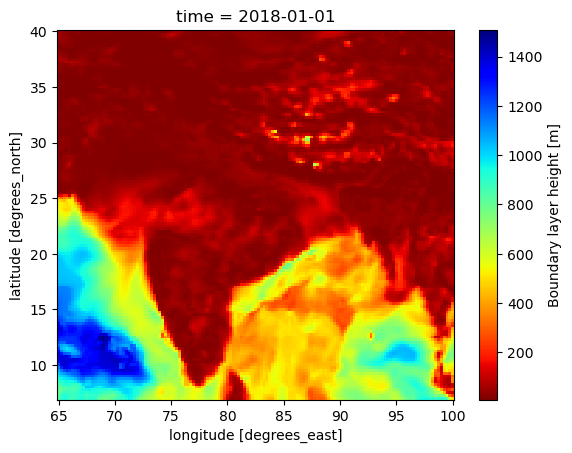

In [17]:
ds.blh.isel(time=0).plot(cmap='jet_r')
plt.show()

# Masking Dataset Using India Boundary Shape File

In [18]:
# Shaping dataset
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude="lat", longitude="lon",
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    shp_gpd = gpd.read_file(shp_path)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')
    return xr_da

In [19]:
sf_dir = './Data/India_Boundary/India_Boundary.shp'

ds_mask = add_shape_coord_from_data_array(ds, sf_dir, "MASK")
ds_mask = ds_mask.where(ds_mask.MASK==0, other=np.nan)
ds_shape = ds_mask.drop_vars('MASK')

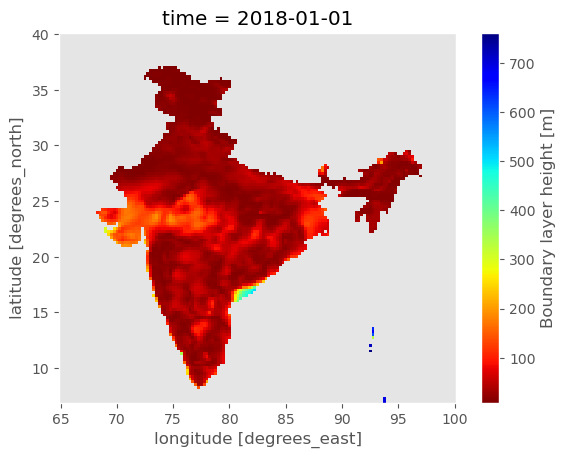

In [37]:
ds_shape.blh.isel(time=0).plot(cmap='jet_r')
plt.show()

# Plot line graph of BLH for all over india

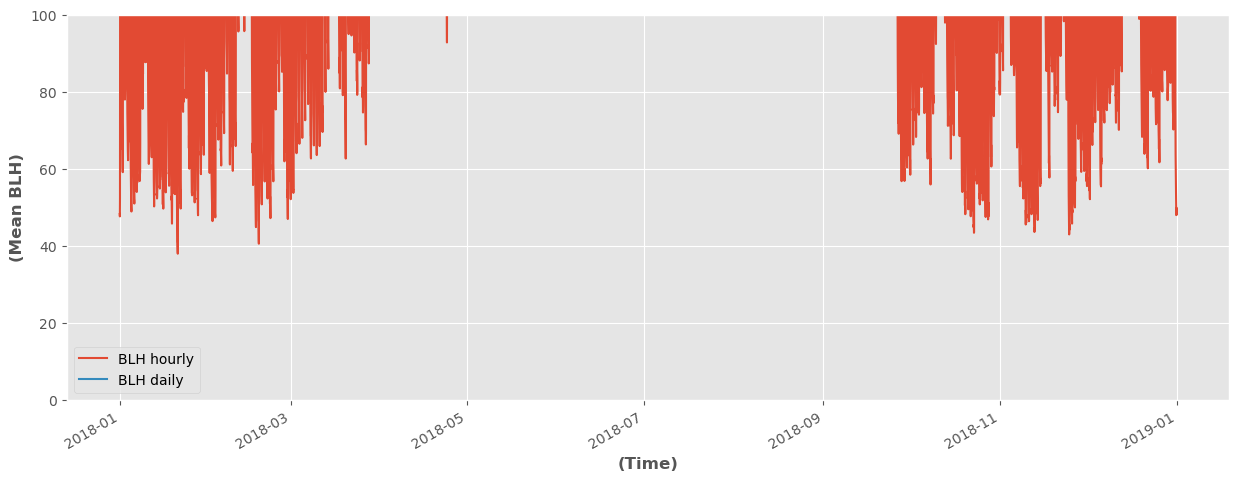

In [39]:
fig,axs = plt.subplots(1,1,figsize=(15,5))

data1_mean = ds_shape.blh.mean(dim=('latitude', 'longitude'))
data2_mean = ds_shape.blh.resample(time='1D').mean().mean(dim=('latitude', 'longitude'))

data1_mean.plot.line(ax=axs, label='BLH hourly')
data2_mean.plot.line(ax=axs, label='BLH daily')

axs.legend()
axs.set_ylim(0,100)
axs.set_xlabel('(Time)',weight='bold')
axs.set_ylabel('(Mean BLH)',weight='bold')
plt.show()

## Reindexing latitude from (38,8) to (8,38)

In [ ]:
# #Reversing the lattitude value 
# ds1 = ds.reindex(latitude=ds.latitude[::-1])
# ds1

## Slicing longitude and latitude between (8,38) and (68,98) respectively

In [ ]:
ds2 = ds1.sel(latitude=slice(8.0,38.0),longitude=slice(68.0,98.0))
ds2.blh.min()

## Plotting Graph

In [ ]:
fig = plt.figure(figsize=(7,5))
cmap = plt.cm.get_cmap('jet')
projection=ccrs.PlateCarree(central_longitude=0)
ax=plt.axes(projection=projection)

#lat and long limits

ds2.blh.isel(time=7).plot(vmin=0, vmax=1500,robust=True,cmap=cmap.reversed(),ax = ax)
ax.set_extent([68,98,8,38], crs=projection)
ax.coastlines() #adding coastline
#ax.gridlines() #adding gridlines
ax.set_xticks(ds.longitude[::10])
ax.set_yticks(ds.latitude[::10])
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', edgecolor='black') ##Adding borders
ax.add_feature(cartopy.feature.STATES, linestyle='-', edgecolor='black') ##adding state borders
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
fig1 = ds2.blh.sel(latitude=23.0225,longitude=72.5714,method='nearest').plot(x='time',marker = 'o',color = 'cyan',label='Ahmedabad' )
fig2 = ds2.blh.sel(latitude=26.84,longitude=80.9462,method='nearest').plot(x='time',marker = 'o',color = 'red',label='lucknow')
plt.xticks(ds2.blh.time)
plt.legend()
plt.show()
